<a href="https://colab.research.google.com/github/yohanes-erwin/notebook/blob/main/lstm_predictive_maintenance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)
%cd /gdrive/My Drive/Colab Notebooks

Mounted at /gdrive
/gdrive/My Drive/Colab Notebooks


### Data Preprocessing

Load data dari file .json.

In [3]:
df_train = pd.read_json('PM_logsynth_train.json', lines=True)
print('Shape of Train dataset: ', df_train.shape)
df_train.head(5)

Shape of Train dataset:  (13538, 5)


,cycle,s1,s2,failure,max_life
0,0,97,1.176117,0,577
1,1,65,0.000723,0,577
2,2,4,0.921732,0,577
3,3,95,0.177239,0,577
4,4,20,3.626983,0,577


In [4]:
# Menambahkan kolom data untuk "remaining useful life (rul)""
df_train['rul'] = df_train['max_life'] - df_train['cycle']
df_train.head(5)

,cycle,s1,s2,failure,max_life,rul
0,0,97,1.176117,0,577,577
1,1,65,0.000723,0,577,576
2,2,4,0.921732,0,577,575
3,3,95,0.177239,0,577,574
4,4,20,3.626983,0,577,573


In [5]:
# Menambahkan kolom data untuk "about to fail"
about_to_fail_window = 50
df_train['about_to_fail'] = np.where((df_train['rul'] <= about_to_fail_window), 1, 0)
df_train.head(df_train['max_life'][0]+3).tail(6)

,cycle,s1,s2,failure,max_life,rul,about_to_fail
574,574,558,0.782795,0,577,3,1
575,575,664,0.920564,0,577,2,1
576,576,744,1.157950,0,577,1,1
577,577,971,1.111066,1,577,0,1
578,578,912,0.727394,1,577,-1,1
579,579,740,1.056534,1,577,-2,1


In [6]:
df_test = pd.read_json('PM_logsynth_test1.json', lines=True)
df_test['rul'] = df_test['max_life'] - df_test['cycle']
df_test['about_to_fail'] = df_test['rul'].apply(lambda x: 1 if x <= about_to_fail_window else 0)

In [7]:
print('Shape of Test dataset: ', df_test.shape)
df_test.head(5)

Shape of Test dataset:  (600, 7)


,cycle,s1,s2,failure,max_life,rul,about_to_fail
0,0,88,1.012152,0,550,550,0
1,1,94,0.425117,0,550,549,0
2,2,12,0.071812,0,550,548,0
3,3,72,0.008297,0,550,547,0
4,4,58,4.495535,0,550,546,0


### Feature Scaling

Feature scaling untuk data Train.

In [8]:
features_cols = ['cycle', 's1', 's2', 'about_to_fail']

In [9]:
df_train.columns.difference(features_cols)

Index(['failure', 'max_life', 'rul'], dtype='object')

In [10]:
min_max_scaler = MinMaxScaler()
cols_normalize = df_train.columns.difference(features_cols)
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(df_train[cols_normalize]), columns=cols_normalize, index=df_train.index)

In [11]:
norm_train_df

,failure,max_life,rul
0,0.0,0.252632,0.899291
1,0.0,0.252632,0.897872
2,0.0,0.252632,0.896454
3,0.0,0.252632,0.895035
4,0.0,0.252632,0.893617
...,...,...,...
13533,1.0,0.715789,0.015603
13534,1.0,0.715789,0.014184
13535,1.0,0.715789,0.012766
13536,1.0,0.715789,0.011348


In [12]:
join_df = df_train[df_train.columns.difference(cols_normalize)].join(norm_train_df)
df_train = join_df.reindex(columns=df_train.columns)

In [13]:
df_train

,cycle,s1,s2,failure,max_life,rul,about_to_fail
0,0,97,1.176117,0.0,0.252632,0.899291,0
1,1,65,0.000723,0.0,0.252632,0.897872,0
2,2,4,0.921732,0.0,0.252632,0.896454,0
3,3,95,0.177239,0.0,0.252632,0.895035,0
4,4,20,3.626983,0.0,0.252632,0.893617,0
...,...,...,...,...,...,...,...
13533,667,730,1.230179,1.0,0.715789,0.015603,1
13534,668,711,1.883210,1.0,0.715789,0.014184,1
13535,669,973,0.761515,1.0,0.715789,0.012766,1
13536,670,628,1.289488,1.0,0.715789,0.011348,1


Feature scaling untuk data Test.

In [14]:
cols_normalize = df_test.columns.difference(features_cols)
norm_test_df = pd.DataFrame(min_max_scaler.fit_transform(df_test[cols_normalize]), columns=cols_normalize, index=df_test.index)
join_df = df_test[df_test.columns.difference(cols_normalize)].join(norm_test_df)
df_test = join_df.reindex(columns=df_test.columns)

In [15]:
df_test

,cycle,s1,s2,failure,max_life,rul,about_to_fail
0,0,88,1.012152,0.0,0.0,1.000000,0
1,1,94,0.425117,0.0,0.0,0.998331,0
2,2,12,0.071812,0.0,0.0,0.996661,0
3,3,72,0.008297,0.0,0.0,0.994992,0
4,4,58,4.495535,0.0,0.0,0.993322,0
...,...,...,...,...,...,...,...
595,595,635,0.939561,1.0,0.0,0.006678,1
596,596,669,0.938573,1.0,0.0,0.005008,1
597,597,998,0.771272,1.0,0.0,0.003339,1
598,598,786,0.761083,1.0,0.0,0.001669,1


### Data embedding

In [16]:
def gen_sequence(id_df, seq_length, seq_cols):
  df_zeros = pd.DataFrame(np.zeros((seq_length-1, id_df.shape[1])), columns=id_df.columns)
  id_df = df_zeros.append(id_df, ignore_index=True)
  data_array = id_df[seq_cols].values
  num_elements = data_array.shape[0]
  lstm_array = []
  for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
    lstm_array.append(data_array[start:stop, :])
  return np.array(lstm_array)

In [17]:
def gen_label(id_df, seq_length, seq_cols, label):
  df_zeros = pd.DataFrame(np.zeros((seq_length-1, id_df.shape[1])), columns=id_df.columns)
  id_df = df_zeros.append(id_df, ignore_index=True)
  data_array = id_df[seq_cols].values
  num_elements = data_array.shape[0]
  y_label = []
  for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
    y_label.append(id_df[label][stop])
  return np.array(y_label)

In [18]:
seq_length = 100
seq_cols = features_cols = ['cycle', 's1', 's2']

In [19]:
# Generate X_train
X_train = np.array(list(gen_sequence(df_train, seq_length, seq_cols)))
print(X_train.shape)
# Generate y_train
y_train = np.array(list(gen_label(df_train, seq_length, seq_cols, 'about_to_fail')))
print(y_train.shape)

<ipython-input-16-9f64be3a1101>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_zeros.append(id_df, ignore_index=True)
<ipython-input-17-16aa0efacc44>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_zeros.append(id_df, ignore_index=True)


(13537, 100, 3)
(13537,)


In [20]:
X_train[1,:,:]

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000

In [21]:
y_train[1]

0.0

In [22]:
# Generate X_test
X_test = np.array(list(gen_sequence(df_test, seq_length, seq_cols)))
print(X_test.shape)
# Generate y_test
y_test = np.array(list(gen_label(df_test, seq_length, seq_cols, 'about_to_fail')))
print(y_test.shape)

(599, 100, 3)
(599,)


<ipython-input-16-9f64be3a1101>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_zeros.append(id_df, ignore_index=True)
<ipython-input-17-16aa0efacc44>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_zeros.append(id_df, ignore_index=True)


### LSTM Network

Membuat model LSTM.

In [23]:
nb_features = X_train.shape[2]
timestamp = seq_length

In [24]:
model = Sequential()

In [25]:
model.add(LSTM(input_shape=(timestamp,nb_features), units=100, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1, activation='sigmoid'))

In [26]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 100)          41600     
                                                                 
 dropout (Dropout)           (None, 100, 100)          0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                30200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 71851 (280.67 KB)
Trainable params: 71851 (280.67 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [28]:
history = model.fit(X_train, y_train, epochs=5, batch_size=10, validation_split=0.05, verbose=2,
                    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                               keras.callbacks.ModelCheckpoint('lstm_predictive_maintenance.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=0)])

Epoch 1/5
1286/1286 - 65s - loss: 0.0525 - accuracy: 0.9851 - val_loss: 0.0450 - val_accuracy: 0.9897 - 65s/epoch - 50ms/step
Epoch 2/5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1286/1286 - 73s - loss: 0.0443 - accuracy: 0.9872 - val_loss: 0.0226 - val_accuracy: 0.9926 - 73s/epoch - 56ms/step
Epoch 3/5
1286/1286 - 57s - loss: 0.0430 - accuracy: 0.9872 - val_loss: 0.0274 - val_accuracy: 0.9911 - 57s/epoch - 45ms/step
Epoch 4/5
1286/1286 - 56s - loss: 0.0427 - accuracy: 0.9875 - val_loss: 0.0310 - val_accuracy: 0.9911 - 56s/epoch - 44ms/step
Epoch 5/5
1286/1286 - 54s - loss: 0.0432 - accuracy: 0.9872 - val_loss: 0.0259 - val_accuracy: 0.9897 - 54s/epoch - 42ms/step


Plot loss dari hasil training.

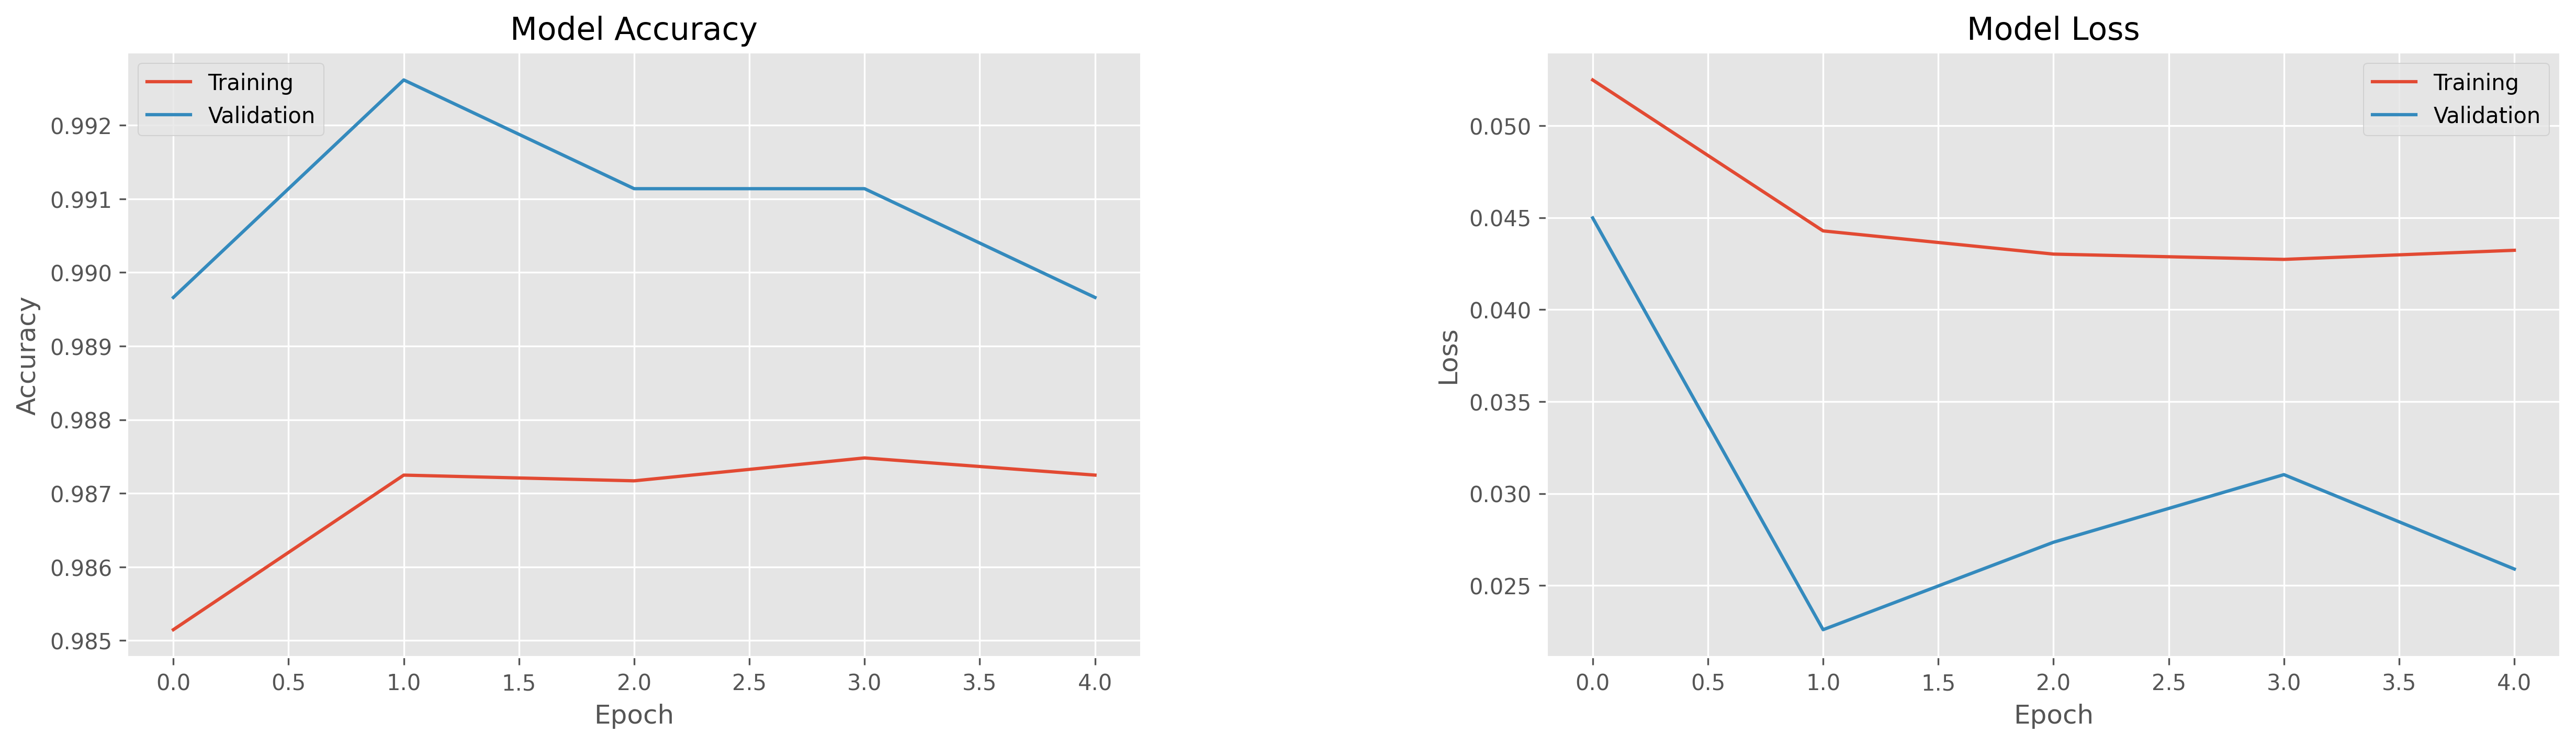

In [29]:
# Plot accuracy
fig_acc = plt.figure(figsize=(20,5), dpi=300)
plt.subplot(1, 2, 1)
plt.subplots_adjust(hspace=0.4, wspace=0.4)
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(history.history['accuracy'], label='training')
plt.plot(history.history['val_accuracy'], label='validation')
plt.legend(['Training','Validation'], loc='upper left')
# Plot loss
plt.subplot(1, 2, 2)
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='validation')
plt.legend(['Training','Validation'], loc='upper right')
plt.show()

Save model menjadi file.

In [30]:
# Save history
import pickle
filename = open("lstm_predictive_maintenance_history", "wb")
pickle.dump(history, filename)
filename.close()

In [31]:
# Save model to JSON
model_json = model.to_json()
with open("lstm_predictive_maintenance.json", "w") as json_file:
  json_file.write(model_json)

In [32]:
# Save weights to HDF5
model.save_weights("lstm_predictive_maintenance.h5")
print("Saved model to disk")

Saved model to disk


### Inference

Load model dari file, sehingga tidak perlu melakukan traning ulang.

In [33]:
# Load history
import pickle
history_file = open("lstm_predictive_maintenance_history", "rb")
history = pickle.load(history_file)
history_file.close()

In [34]:
# Load model from json
from keras.models import model_from_json
json_file = open("lstm_predictive_maintenance.json", "r")
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)

In [35]:
# Load weights from HDF5
model.load_weights("lstm_predictive_maintenance.h5")
print("Loaded model from disk")
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Loaded model from disk


Melakukan prediksi dan menghitung confusion matrix.

In [36]:
# Make predictions and compute confusion matrix
scores = model.evaluate(X_train, y_train, verbose=1, batch_size=200)
y_pred = model.predict(X_train, verbose=1, batch_size=200)
y_pred_class = np.round(y_pred)
y_true = y_train
print('Accuracy of predictions made on data used for training = {}'.format(scores[1]))
# Compute precision and recall
precision = precision_score(y_true, y_pred_class)
recall = recall_score(y_true, y_pred_class)
print('Precision = ' + str(precision) + '\nRecall = ' + str(recall))

68/68 [==============================] - 8s 113ms/step
Accuracy of predictions made on data used for training = 0.9873679280281067
Precision = 0.93757051523129
Recall = 0.9979983987189752


Membandingkan dengan ground truth.

In [37]:
print('Confusion matrix on training data:\n- x-axis is true labels\n- y-axis is predicted labels')
cm = confusion_matrix(y_true, y_pred_class)
pd.DataFrame(cm).head(2)

Confusion matrix on training data:
- x-axis is true labels
- y-axis is predicted labels


,0,1
0,10873,166
1,5,2493


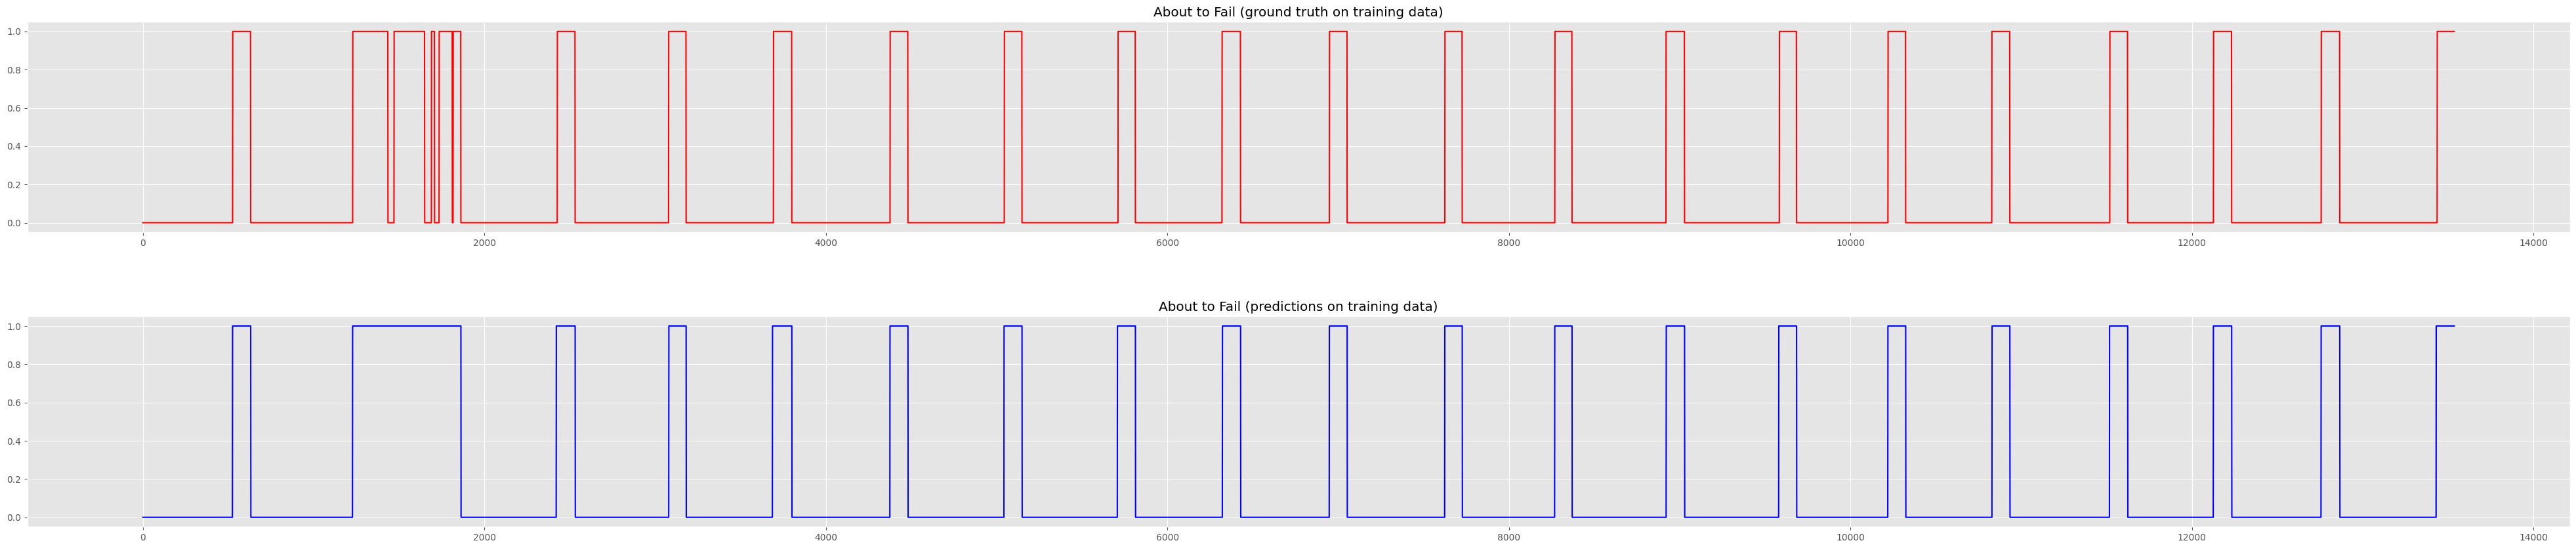

In [38]:
plt.figure(figsize=(50,10))
plt.subplot(2, 1, 1)
plt.subplots_adjust(hspace=0.4, wspace=0.4)
plt.title("About to Fail (ground truth on training data)")
plt.plot(y_true, 'r')
plt.subplot(2, 1, 2)
plt.subplots_adjust(hspace=0.4, wspace=0.4)
plt.title("About to Fail (predictions on training data)")
plt.plot(y_pred_class, 'b')

Evaluasi dengan data Test.

In [39]:
y_pred2 = model.predict(X_test)
y_pred2_class = np.round(y_pred2)

19/19 [==============================] - 0s 23ms/step


In [40]:
print('Accuracy of model on test data = ' + str(accuracy_score(y_test, y_pred2_class)))
print('Confusion matrix on training data:\n- x-axis is true labels\n- y-axis is predicted labels')
pd.DataFrame(confusion_matrix(y_test, y_pred2_class)).head(2)

Accuracy of model on test data = 0.9131886477462438
Confusion matrix on training data:
- x-axis is true labels
- y-axis is predicted labels


,0,1
0,499,0
1,52,48


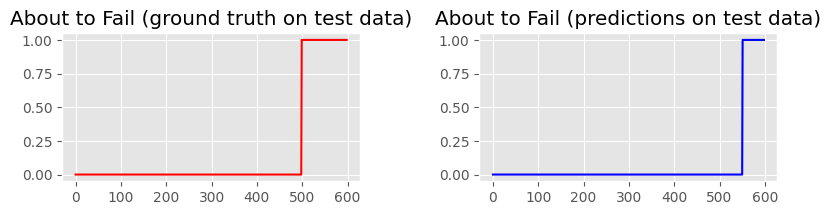

In [41]:
plt.figure(figsize=(20,10))
plt.subplot(4, 4, 1)
plt.subplots_adjust(hspace=0.4, wspace=0.4)
plt.title("About to Fail (ground truth on test data)")
plt.plot(y_test, 'r')
plt.subplot(4, 4, 2)
plt.subplots_adjust(hspace=0.4, wspace=0.4)
plt.title("About to Fail (predictions on test data)")
plt.plot(y_pred2_class, 'b')

### Deployment Function

In [42]:
def prob_failure(df):
  test = gen_sequence(df, seq_length, seq_cols)
  m_pred = model.predict(test)
  failure_prob = list(m_pred[-1])[0]
  return failure_prob

def plot_prediction(df):
  X_test3 = np.array(list(gen_sequence(df, seq_length, seq_cols)))
  y_test3 = np.array(list(gen_label(df_test, seq_length, seq_cols, 'about_to_fail')))
  y_pred3_prob = model.predict(X_test3)
  y_pred3 = np.round(y_pred3_prob)
  confidence = model.predict(gen_sequence(df, seq_length, seq_cols))
  plt.figure(figsize=(20,10), dpi=150)
  plt.subplot(4, 4, 1)
  plt.subplots_adjust(hspace=0.4, wspace=0.4)
  plt.title("About to Fail within " + str(about_to_fail_window) + " cycles")
  plt.ylim(-0.1, 1.1)
  plt.xlabel('Cycles')
  plt.yticks(np.arange(2), ('False','True'))
  plt.plot(df['about_to_fail'], 'r', label='Actual')
  plt.plot(y_pred3, 'b', label='Predicted')
  plt.legend(loc='upper left')
  plt.subplot(4, 4, 2)
  plt.title("Probability of Failure")
  plt.ylim(-0.1, 1.1)
  plt.xlabel('Cycles')
  plt.plot(confidence, 'r')
  print('Probability of failure within ' + str(about_to_fail_window) + " cycles: {0:.1%}".format(prob_failure(df)))
  print('Accuracy Score: {0:.2}'.format(accuracy_score(y_test3, y_pred3)))
  print('Confusion matrix:\n- x-axis is true labels\n- y-axis is predicted labels')
  print(pd.DataFrame(confusion_matrix(y_test3, y_pred3)).head(2))

 4/19 [=====>........................] - ETA: 0s

<ipython-input-16-9f64be3a1101>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_zeros.append(id_df, ignore_index=True)
<ipython-input-17-16aa0efacc44>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_zeros.append(id_df, ignore_index=True)


 4/19 [=====>........................] - ETA: 0s

<ipython-input-16-9f64be3a1101>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_zeros.append(id_df, ignore_index=True)


 4/19 [=====>........................] - ETA: 0s

<ipython-input-16-9f64be3a1101>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_zeros.append(id_df, ignore_index=True)


19/19 [==============================] - 0s 24ms/step
Probability of failure within 50 cycles: 99.5%
Accuracy Score: 0.91
Confusion matrix:
- x-axis is true labels
- y-axis is predicted labels
     0   1
0  499   0
1   52  48


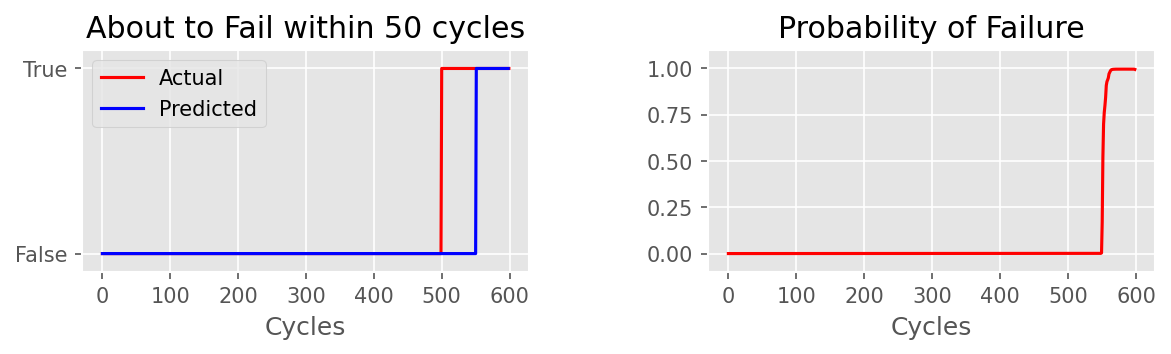

In [43]:
df = pd.read_json('PM_logsynth_test1.json', lines=True)
df['rul'] = df['max_life'] - df['cycle']
df['about_to_fail'] = np.where((df['rul'] <= about_to_fail_window), 1, 0)
plot_prediction(df)

 4/19 [=====>........................] - ETA: 0s

<ipython-input-16-9f64be3a1101>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_zeros.append(id_df, ignore_index=True)
<ipython-input-17-16aa0efacc44>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_zeros.append(id_df, ignore_index=True)


 4/19 [=====>........................] - ETA: 0s

<ipython-input-16-9f64be3a1101>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_zeros.append(id_df, ignore_index=True)


 4/19 [=====>........................] - ETA: 0s

<ipython-input-16-9f64be3a1101>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_zeros.append(id_df, ignore_index=True)


19/19 [==============================] - 0s 23ms/step
Probability of failure within 50 cycles: 0.0%
Accuracy Score: 0.83
Confusion matrix:
- x-axis is true labels
- y-axis is predicted labels
     0  1
0  499  0
1  100  0


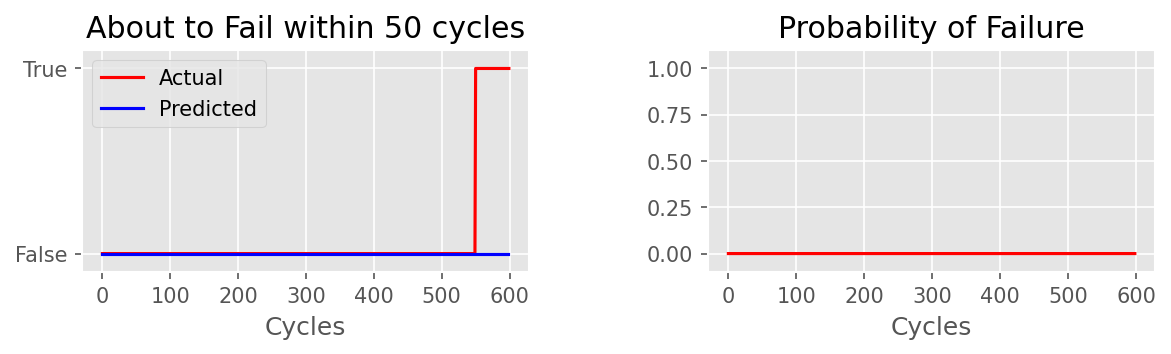

In [44]:
df = pd.read_json('PM_logsynth_test2.json', lines=True)
df['rul'] = df['max_life'] - df['cycle']
df['about_to_fail'] = np.where((df['rul'] <= about_to_fail_window), 1, 0)
plot_prediction(df)

 5/19 [======>.......................] - ETA: 0s

<ipython-input-16-9f64be3a1101>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_zeros.append(id_df, ignore_index=True)
<ipython-input-17-16aa0efacc44>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_zeros.append(id_df, ignore_index=True)


 3/19 [===>..........................] - ETA: 0s

<ipython-input-16-9f64be3a1101>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_zeros.append(id_df, ignore_index=True)


 2/19 [==>...........................] - ETA: 0s

<ipython-input-16-9f64be3a1101>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_zeros.append(id_df, ignore_index=True)


19/19 [==============================] - 1s 30ms/step
Probability of failure within 50 cycles: 92.3%
Accuracy Score: 0.65
Confusion matrix:
- x-axis is true labels
- y-axis is predicted labels
     0    1
0  291  208
1    0  100


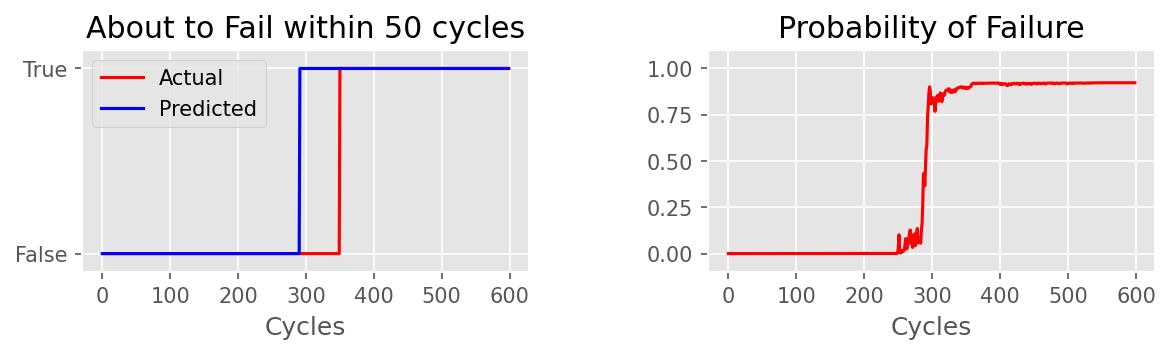

In [45]:
df = pd.read_json('PM_logsynth_test3.json', lines=True)
df['rul'] = df['max_life'] - df['cycle']
df['about_to_fail'] = np.where((df['rul'] <= about_to_fail_window), 1, 0)
plot_prediction(df)

 4/19 [=====>........................] - ETA: 0s

<ipython-input-16-9f64be3a1101>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_zeros.append(id_df, ignore_index=True)
<ipython-input-17-16aa0efacc44>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_zeros.append(id_df, ignore_index=True)


 7/19 [==========>...................] - ETA: 0s

<ipython-input-16-9f64be3a1101>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_zeros.append(id_df, ignore_index=True)


 4/19 [=====>........................] - ETA: 0s

<ipython-input-16-9f64be3a1101>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_zeros.append(id_df, ignore_index=True)


19/19 [==============================] - 0s 23ms/step
Probability of failure within 50 cycles: 92.3%
Accuracy Score: 0.73
Confusion matrix:
- x-axis is true labels
- y-axis is predicted labels
     0    1
0  336  163
1    0  100


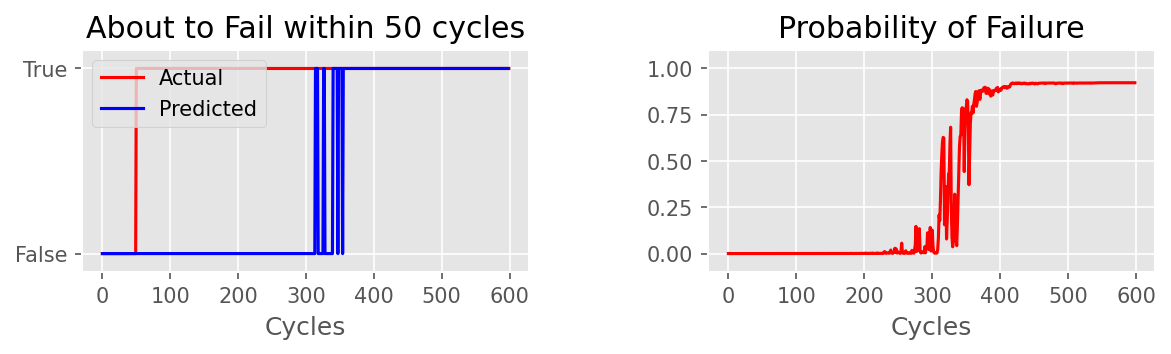

In [46]:
df = pd.read_json('PM_logsynth_test4.json', lines=True)
df['rul'] = df['max_life'] - df['cycle']
df['about_to_fail'] = np.where((df['rul'] <= about_to_fail_window), 1, 0)
plot_prediction(df)